In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to /Users/DonJuve/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/DonJuve/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/DonJuve/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df= pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
# Rename the columns
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

# Check the updated DataFrame
print(df.head())


                                          tweet_text            products  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

           emotions  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion  


In [9]:
df.head(20)

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [10]:
df['emotions'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotions, dtype: int64

In [11]:
# Replace the value in the 'emotions' column
df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'No emotion')

# Check the updated distribution
print(df['emotions'].value_counts())

No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: emotions, dtype: int64


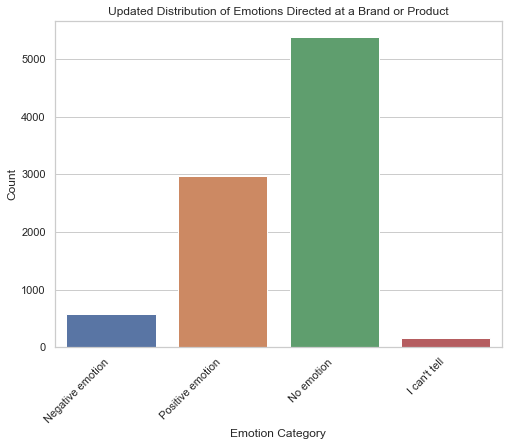

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Plot the updated distribution of emotions
plt.figure(figsize=(8, 6))
sns.countplot(x='emotions', data=df)
plt.title('Updated Distribution of Emotions Directed at a Brand or Product')
plt.xlabel('Emotion Category')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
df['products'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: products, dtype: int64

/Users/DonJuve/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


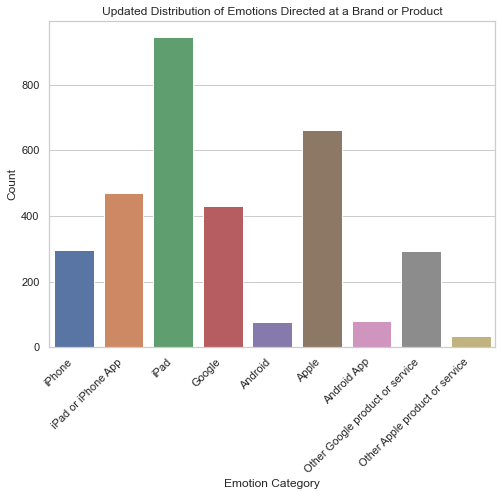

In [14]:
# Plot the updated distribution of emotions
plt.figure(figsize=(8, 6))
#sns.countplot(x='products', data=df)
sns.countplot(df['products'])
plt.title('Updated Distribution of Emotions Directed at a Brand or Product')
plt.xlabel('Emotion Category')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   products    3291 non-null   object
 2   emotions    9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [16]:
df['tweet_text'][:50]

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                   NaN
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
11    Find &amp; Start Impromptu Parties at #SXSW Wi...
12    Foursquare ups the game, just in time for #SXS...
13    Gotta love this #SXSW Google Calendar featurin...
14    Great #sxsw ipad app from @madebymany: http://...
15    haha, awesomely rad iPad app by @madebymany ht...
16    Holler Gram for iPad on the iTunes App Store -...
17    I just noticed DST is coming this weekend.

he 'tweet_text' column appears to contain text data related to tweets. Each entry in the column represents a tweet and may include various elements such as mentions, hashtags, and content related to events like the SXSW (South by Southwest) festival. Some tweets are in response to specific users, while others contain information about applications, devices (e.g., iPad, iPhone), and announcements.

Here are some observations about the content:

Mentions: Tweets often include mentions of other users, indicated by the '@' symbol followed by a username (e.g., "@wesley83", "@jessedee").

Hashtags: Hashtags are used to categorize tweets and make them searchable. They start with the '#' symbol (e.g., "#iPad", "#SXSW").

Content: The actual content of the tweets varies, including discussions about technology, applications, and events.

Links: Some tweets contain URLs or links (e.g., "http://", "{link}").

Miscellaneous characters: There are some non-alphanumeric characters present, including special symbols, emojis, and Unicode escape sequences.



In [17]:
df['products'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: products, dtype: int64

In [18]:
df['products'].isna().sum()

5802

In [19]:
df[df['products'].isna()].head(50)

,tweet_text,products,emotions
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion
6,NaN,NaN,No emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion
35,At #sxsw. Oooh. RT @mention Google to Launch ...,NaN,No emotion
37,SPIN Play - a new concept in music discovery f...,NaN,No emotion
39,VatorNews - Google And Apple Force Print Media...,NaN,No emotion
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,No emotion


In [20]:
apple_products = [
    'iPhone',
    'iPad',
    'MacBook',
    'iMac',
    'Mac Mini',
    'Apple Watch',
    'AirPods',
    'HomePod',
]

android_products = [
    'Samsung Galaxy',
    'Google Pixel',
    'OnePlus',
    'LG G series',
    'Huawei P series',
]

# List of Google products
google_products = [
    'Google Pixel',
    'Google Home',
    'Google Nest',
    'Chromecast',
    'Pixelbook',
]

In [21]:
# Function to update products based on the tweet text
def update_products(tweet_text):
    if pd.notna(tweet_text):
        if any(product.lower() in tweet_text.lower() for product in apple_products):
            return 'Apple'
        elif any(product.lower() in tweet_text.lower() for product in android_products):
            return 'Android'
        elif any(product.lower() in tweet_text.lower() for product in google_products):
            return 'Google'
    return pd.NA  # or any value you want for other cases


In [22]:
df[df['products'].isna()].head(50) 

,tweet_text,products,emotions
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion
6,NaN,NaN,No emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion
35,At #sxsw. Oooh. RT @mention Google to Launch ...,NaN,No emotion
37,SPIN Play - a new concept in music discovery f...,NaN,No emotion
39,VatorNews - Google And Apple Force Print Media...,NaN,No emotion
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,No emotion


In [23]:
import re

#filter to dectect non ascci caracters and return boolean value in ascii
df['ascii'] = df['tweet_text'].apply(lambda x: bool(re.search(r'[:;]-?[\)DPO\(]', str(x))))

# Display the result
print(df[['tweet_text', 'ascii']])

                                             tweet_text  ascii
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...  False
1     @jessedee Know about @fludapp ? Awesome iPad/i...  False
2     @swonderlin Can not wait for #iPad 2 also. The...  False
3     @sxsw I hope this year's festival isn't as cra...  False
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...  False
...                                                 ...    ...
9088                      Ipad everywhere. #SXSW {link}  False
9089  Wave, buzz... RT @mention We interrupt your re...  False
9090  Google's Zeiger, a physician never reported po...  False
9091  Some Verizon iPhone customers complained their...  False
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...  False

[9093 rows x 2 columns]


In [24]:
df['ascii'].value_counts()

False    8816
True      277
Name: ascii, dtype: int64

In [25]:
df[df['ascii']].head(50)

,tweet_text,products,emotions,ascii
78,iPad2? RT @mention Droid &amp; Mac here :) RT ...,NaN,No emotion,True
174,I went to #sxswi and all I won was this lousy ...,iPad,Positive emotion,True
186,Currently 150 people in line at the &quot;Pop ...,NaN,No emotion,True
201,U = smart 4 packing an extra :) RT @mention On...,NaN,No emotion,True
215,Now thats a NEWS :P RT@mention Google to Launc...,NaN,No emotion,True
257,"Do I need any more for #sxsw! ipad, iphone, la...",iPhone,Positive emotion,True
260,Our #sxsw app is now on #android :D huge props...,NaN,No emotion,True
267,BREAKING: Apple announces partnership w/porn i...,NaN,No emotion,True
288,ÛÏ@mention Apple store downtown Austin open t...,Apple,Positive emotion,True
296,Temporary Apple store at SXSW is really cool.....,iPad,Positive emotion,True


In [26]:
dfNaN = df[(df['products'].isna()) & (df['emotions'] == 'No emotion')].copy()

# Display the new DataFrame
dfNaN

,tweet_text,products,emotions,ascii
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion,False
6,NaN,NaN,No emotion,False
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion,False
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion,False
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion,False
...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion,False
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion,False
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion,False
9091,Some Verizon iPhone customers complained their...,NaN,No emotion,False


Ref: article ref: https://arxiv.org/pdf/1511.02556.pdf

In [27]:


# Define the positive emoticons
positive_emoticons = [":')", "XP", "xD", "8)", ":-P", "=]", ":p", ";P", ":P", "XD", "(:", "=)", ":]", ";)", "=D", ";-)", ";D", ":-D", ":-)", ":)", ":D"]

# Define the negative emoticons
negative_emoticons = [":(", ":'(", ":-(", ";(", ">:(", ":/", ":-/", "D:", ":\\", "DX"]

#create a new column new_e to test the column update
dfNaN['new_e'] = None

# Update 'new_e' based on positive and negative emoticons
positive_pattern = '|'.join(map(re.escape, positive_emoticons))
negative_pattern = '|'.join(map(re.escape, negative_emoticons))

# Use fillna to replace NaN values in 'tweet_text' with an empty string
dfNaN['tweet_text'] = dfNaN['tweet_text'].fillna('')

dfNaN.loc[dfNaN['tweet_text'].str.contains(positive_pattern), 'new_e'] = 'Positive emotion'
dfNaN.loc[dfNaN['tweet_text'].str.contains(negative_pattern), 'new_e'] = 'Negative emotion'

# Display the updated DataFrame
dfNaN

,tweet_text,products,emotions,ascii,new_e
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion,False,Negative emotion
6,,NaN,No emotion,False,None
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion,False,Negative emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion,False,None
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion,False,None
...,...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion,False,None
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion,False,None
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion,False,None
9091,Some Verizon iPhone customers complained their...,NaN,No emotion,False,None


In [28]:
dfNaN['new_e'].value_counts()

Positive emotion    142
Negative emotion     25
Name: new_e, dtype: int64

In [29]:
import emoji
import regex as re

# Function to check if a text contains miscellaneous characters
def contains_misc_characters(text):
    if isinstance(text, str):
        pattern = re.compile(r'[\x00-\x7F]+')  # Matches non-ASCII characters
        return not pattern.match(text)
    return False

# Apply the function to each line in the 'tweet_text' column and create a new 'tweet_misc' column
df['tweet_misc'] = df['tweet_text'].apply(contains_misc_characters)

# Display the result
print(df[['tweet_text', 'tweet_misc']])

                                             tweet_text  tweet_misc
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...       False
1     @jessedee Know about @fludapp ? Awesome iPad/i...       False
2     @swonderlin Can not wait for #iPad 2 also. The...       False
3     @sxsw I hope this year's festival isn't as cra...       False
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...       False
...                                                 ...         ...
9088                      Ipad everywhere. #SXSW {link}       False
9089  Wave, buzz... RT @mention We interrupt your re...       False
9090  Google's Zeiger, a physician never reported po...       False
9091  Some Verizon iPhone customers complained their...       False
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...        True

[9093 rows x 2 columns]


In [30]:
df['tweet_misc'].value_counts()

False    8983
True      110
Name: tweet_misc, dtype: int64

In [31]:
df[df['tweet_misc']]

,tweet_text,products,emotions,ascii,tweet_misc
51,ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...,NaN,No emotion,False,True
52,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...,NaN,No emotion,False,True
54,ÛÏ@mention @mention #Google Will Connect the ...,NaN,No emotion,False,True
55,ÛÏ@mention @mention talking about {link} - Go...,Google,Positive emotion,False,True
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell,False,True
...,...,...,...,...,...
7620,ÛÏFoursquare for bands&quot; just in time for...,iPad or iPhone App,Positive emotion,False,True
8014,ÛÏThe classiest fascist company in existence...,Apple,Negative emotion,False,True
8214,÷¼ As right as rain! ÷_ {link} ã_ #edchat #...,NaN,No emotion,False,True
8234,÷¼ We canÛªt get no frustrationÛ_÷_ {link}...,NaN,No emotion,False,True


In [32]:
df['products'].isna().sum()

5802

In [33]:
df.shape


(9093, 5)

In [34]:
# Drop rows where 'tweet_misc' is True and 'products' is NaN
df = df[~(df['tweet_misc'] & df['products'].isna())].reset_index(drop=True)

In [35]:
df.shape # - 74 columns

(9019, 5)

In [36]:
df[df['tweet_misc']].shape

(36, 5)

In [37]:
df = df[~df['tweet_misc']].reset_index(drop=True)

In [38]:
df[df['tweet_misc']].shape

(0, 5)

In [39]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Text tokenization
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:'[a-z]+)?)")
df['tokenized_text'] = df['tweet_text'].apply(lambda x: tokenizer.tokenize(str(x).lower()))

# Stopword removal
stop_words = set(stopwords.words('english'))
#df['cleaned_text'] = df['tokenized_text'].apply(lambda x: [token for token in x if token not in stop_words])
df['cleaned_text'] = df['tokenized_text'].apply(lambda x: [token.replace(',', '') for token in x if token not in stop_words])


In [40]:
df

,tweet_text,products,emotions,ascii,tweet_misc,tokenized_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,False,False,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,False,False,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,False,False,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,False,False,"[sxsw, i, hope, this, year's, festival, isn't,...","[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,False,False,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...,...,...,...
8978,"@mention Yup, but I don't have a third app yet...",NaN,No emotion,False,False,"[mention, yup, but, i, don't, have, a, third, ...","[mention, yup, third, app, yet, i'm, android, ..."
8979,Ipad everywhere. #SXSW {link},iPad,Positive emotion,False,False,"[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]"
8980,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion,False,False,"[wave, buzz, rt, mention, we, interrupt, your,...","[wave, buzz, rt, mention, interrupt, regularly..."
8981,"Google's Zeiger, a physician never reported po...",NaN,No emotion,False,False,"[google's, zeiger, a, physician, never, report...","[google's, zeiger, physician, never, reported,..."


In [41]:
df['emotions'].value_counts()

No emotion          5319
Positive emotion    2946
Negative emotion     563
I can't tell         155
Name: emotions, dtype: int64

In [42]:
#lets double check for emojies

In [43]:
pip install emoji


Note: you may need to restart the kernel to use updated packages.


--reference: https://carpedm20.github.io/emoji/docs/api.html

In [44]:
import emoji

# Function to replace Unicode emojis with emoji shortcodes
def replace_unicode_with_shortcode(text):
    if pd.notna(text):  # Check if the value is not NaN
        return emoji.analyze(text)
    else:
        return text  # Return the NaN value unchanged

# Apply the function to the 'tweet_text' column and update it
df['emoji'] = df['tweet_text'].apply(replace_unicode_with_shortcode)

# Display the updated 'tweet_text' column
print(df['tweet_text'])


0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
8978    @mention Yup, but I don't have a third app yet...
8979                        Ipad everywhere. #SXSW {link}
8980    Wave, buzz... RT @mention We interrupt your re...
8981    Google's Zeiger, a physician never reported po...
8982    Some Verizon iPhone customers complained their...
Name: tweet_text, Length: 8983, dtype: object


In [45]:
df

,tweet_text,products,emotions,ascii,tweet_misc,tokenized_text,cleaned_text,emoji
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,False,False,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, rise, austi...",<generator object filter_tokens at 0x7f935e01e...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,False,False,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon...",<generator object filter_tokens at 0x7f935e01e...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,False,False,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale, sxsw]",<generator object filter_tokens at 0x7f935e01e...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,False,False,"[sxsw, i, hope, this, year's, festival, isn't,...","[sxsw, hope, year's, festival, crashy, year's,...",<generator object filter_tokens at 0x7f935e01e...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,False,False,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...",<generator object filter_tokens at 0x7f935e01e...
...,...,...,...,...,...,...,...,...
8978,"@mention Yup, but I don't have a third app yet...",NaN,No emotion,False,False,"[mention, yup, but, i, don't, have, a, third, ...","[mention, yup, third, app, yet, i'm, android, ...",<generator object filter_tokens at 0x7f935f991...
8979,Ipad everywhere. #SXSW {link},iPad,Positive emotion,False,False,"[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]",<generator object filter_tokens at 0x7f935f991...
8980,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion,False,False,"[wave, buzz, rt, mention, we, interrupt, your,...","[wave, buzz, rt, mention, interrupt, regularly...",<generator object filter_tokens at 0x7f935f991...
8981,"Google's Zeiger, a physician never reported po...",NaN,No emotion,False,False,"[google's, zeiger, a, physician, never, report...","[google's, zeiger, physician, never, reported,...",<generator object filter_tokens at 0x7f935f991...


In [46]:
df['tweet_text'].head(50)

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                   NaN
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
11    Find &amp; Start Impromptu Parties at #SXSW Wi...
12    Foursquare ups the game, just in time for #SXS...
13    Gotta love this #SXSW Google Calendar featurin...
14    Great #sxsw ipad app from @madebymany: http://...
15    haha, awesomely rad iPad app by @madebymany ht...
16    Holler Gram for iPad on the iTunes App Store -...
17    I just noticed DST is coming this weekend.

In [47]:
df['tweet_text'].loc[45]

"#IPad2 's \x89Û÷#SmartCover\x89Ûª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW"

In [60]:
df['cleaned_text'].loc[45]

['ipad',
 'smartcover',
 'opens',
 'instant',
 'access',
 'waited',
 'get',
 'one',
 'link',
 'apple',
 'sxsw']

In [49]:
#def is_emoji(s):
#    emojis = "😘◼️" # add more emojis here
 #   count = 0
 #   for emoji in emojis:
  #      count += s.count(emoji)
  #      if count > 1:
  #          return False
   # return bool(count)

In [50]:
import emoji

# Function to check if a text contains emojis
#def contains_emojis(text):
#    return any(char in emoji.analyze for char in text)

# Apply the function to each line in the 'tweet_text' column
#df['contains_emojis'] = df['tweet_text'].apply(contains_emojis)

# Display the result
#print(df[['tweet_text', 'contains_emojis']])


In [51]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Text tokenization
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:'[a-z]+)?)")
df['tokenized_text'] = df['tweet_text'].apply(lambda x: tokenizer.tokenize(str(x).lower()))

# Stopword removal
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['tokenized_text'].apply(lambda x: [token for token in x if token not in stop_words])


In [52]:
df['tokenized_text'].loc[48]

['orly',
 'mention',
 'google',
 'set',
 'to',
 'launch',
 'new',
 'social',
 'network',
 'circles',
 'today',
 'at',
 'sxsw']

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8983 entries, 0 to 8982
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_text      8982 non-null   object
 1   products        3255 non-null   object
 2   emotions        8983 non-null   object
 3   ascii           8983 non-null   bool  
 4   tweet_misc      8983 non-null   bool  
 5   tokenized_text  8983 non-null   object
 6   cleaned_text    8983 non-null   object
 7   emoji           8982 non-null   object
dtypes: bool(2), object(6)
memory usage: 438.7+ KB


In [54]:
df_clean = df.drop(columns=['ascii','tweet_misc', 'emoji'])
df_clean

,tweet_text,products,emotions,tokenized_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, i, hope, this, year's, festival, isn't,...","[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...,...
8978,"@mention Yup, but I don't have a third app yet...",NaN,No emotion,"[mention, yup, but, i, don't, have, a, third, ...","[mention, yup, third, app, yet, i'm, android, ..."
8979,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]"
8980,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion,"[wave, buzz, rt, mention, we, interrupt, your,...","[wave, buzz, rt, mention, interrupt, regularly..."
8981,"Google's Zeiger, a physician never reported po...",NaN,No emotion,"[google's, zeiger, a, physician, never, report...","[google's, zeiger, physician, never, reported,..."


In [55]:
df_clean = df_clean[df_clean['emotions'].isin(['Positive emotion', 'Negative emotion'])]

In [56]:
df_clean['emotions'].value_counts()

Positive emotion    2946
Negative emotion     563
Name: emotions, dtype: int64

In [57]:
df_clean.loc[10]

tweet_text        Excited to meet the @samsungmobileus at #sxsw ...
products                                                    Android
emotions                                           Positive emotion
tokenized_text    [excited, to, meet, the, samsungmobileus, at, ...
cleaned_text      [excited, meet, samsungmobileus, sxsw, show, s...
Name: 10, dtype: object

In [64]:
from nltk import FreqDist
from itertools import chain

# Flatten the lists in the "tokenized_text" column
flat_tokenized_text = list(chain.from_iterable(df_clean["tokenized_text"]))

# Create FreqDist from the flattened list
example_freq_dist = FreqDist(flat_tokenized_text)

example_freq_dist

FreqDist({'sxsw': 3698, 'mention': 2463, 'the': 1894, 'ipad': 1435, 'to': 1403, 'link': 1299, 'at': 1157, 'rt': 1075, 'for': 1015, 'apple': 999, ...})

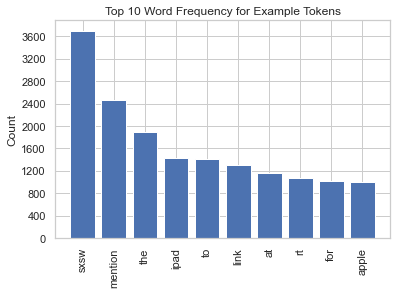

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")

* Performing Train Test Split


In [58]:
X = 
y = 

NameError: name 'corpus' is not defined